
# DJ User stories

Story 1:
Ich als DJ will wissen, welches Genre im Schnitt die höchste Danceability hat, um meine Musikauswahl zu verbessern.

Story 2:
Als DJ will ich Brücken zwischen Subgenres, eine kurze Liste mit fünf Tracks, die zwei Stile im Set nahtlos verbinden.


In [4]:

import os
import time
import base64
import json
import math
import logging
from typing import List, Dict, Tuple, Any, Optional

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")


In [5]:
# Credentials and knobs

# Rapid API
RAPID_API_KEY = "[RAPID_API_KEY]"
RAPID_HOST_TRACK = "track" + chr(45) + "analysis.p.rapidapi.com"
RAPID_REGION = "EU"

# Spotify Web API
SPOTIFY_CLIENT_ID = "[SPOTIFY_CLIENT_ID]"
SPOTIFY_CLIENT_SECRET = "[SPOTIFY_CLIENT_SECRET]"
SPOTIFY_REDIRECT_URI = "http://localhost:8721/callback"

# Limits
MAX_TRACKS_PER_PLAYLIST = 100
DEFAULT_TRACKS_PER_GENRE = 40
REQUEST_TIMEOUT = 20
SLEEP_BETWEEN_CALLS = 0.03



## Rapid API helper


In [6]:

def rapid_get(path: str, params: Dict[str, Any], host: str) -> Dict[str, Any]:
    url = f"https://{host}/{path}"
    headers = {
        "X" + chr(45) + "RapidAPI" + chr(45) + "Key": RAPID_API_KEY,
        "X" + chr(45) + "RapidAPI" + chr(45) + "Host": host,
        "Accept": "application/json",
    }
    if RAPID_REGION:
        headers["X" + chr(45) + "RapidAPI" + chr(45) + "Region"] = RAPID_REGION
    resp = requests.get(url, headers=headers, params=params, timeout=REQUEST_TIMEOUT)
    if resp.status_code in (401, 403, 429):
        try:
            print("Rapid API error body:", resp.json())
        except Exception:
            print("Rapid API error text:", resp.text[:500])
        resp.raise_for_status()
    resp.raise_for_status()
    return resp.json()



## Spotify discovery


In [7]:

_SPOTIFY_TOKEN = None
_SPOTIFY_TOKEN_EXP = 0

def _now() -> int:
    return int(time.time())

def _spotify_token_client_credentials() -> Tuple[str, int]:
    if not SPOTIFY_CLIENT_ID or not SPOTIFY_CLIENT_SECRET:
        raise RuntimeError("Missing client id or secret for client credentials")
    url = "https://accounts.spotify.com/api/token"
    basic = base64.b64encode(f"{SPOTIFY_CLIENT_ID}:{SPOTIFY_CLIENT_SECRET}".encode()).decode()
    headers = {
        "Authorization": f"Basic {basic}",
        "Content" + chr(45) + "Type": "application/x-www-form-urlencoded",
    }
    data = {"grant_type": "client_credentials"}
    r = requests.post(url, headers=headers, data=data, timeout=REQUEST_TIMEOUT)
    if r.status_code != 200:
        try:
            print("Token error body:", r.json())
        except Exception:
            print("Token error text:", r.text[:500])
        r.raise_for_status()
    js = r.json()
    return js["access_token"], _now() + int(js.get("expires_in", 3500))

def _spotify_token_pkce() -> Tuple[str, int]:
    import secrets, hashlib, urllib.parse
    verifier = base64.urlsafe_b64encode(secrets.token_bytes(32)).decode().rstrip("=")
    challenge = base64.urlsafe_b64encode(hashlib.sha256(verifier.encode()).digest()).decode().rstrip("=")
    auth_url = "https://accounts.spotify.com/authorize"
    params = {
        "client_id": SPOTIFY_CLIENT_ID,
        "response_type": "code",
        "redirect_uri": SPOTIFY_REDIRECT_URI,
        "code_challenge_method": "S256",
        "code_challenge": challenge,
        "scope": "playlist-read-private",
    }
    url = auth_url + "?" + urllib.parse.urlencode(params)
    print("Open this URL, approve, then paste the full redirect URL below")
    print(url)
    redirected = input("Paste redirect URL here: ").strip()
    parsed = urllib.parse.urlparse(redirected)
    qs = urllib.parse.parse_qs(parsed.query)
    code = qs.get("code", [None])[0]
    if not code:
        raise RuntimeError("No code found in redirect URL")
    token_url = "https://accounts.spotify.com/api/token"
    data = {
        "client_id": SPOTIFY_CLIENT_ID,
        "grant_type": "authorization_code",
        "code": code,
        "redirect_uri": SPOTIFY_REDIRECT_URI,
        "code_verifier": verifier,
    }
    headers = {"Content" + chr(45) + "Type": "application/x-www-form-urlencoded"}
    r = requests.post(token_url, data=data, headers=headers, timeout=REQUEST_TIMEOUT)
    if r.status_code != 200:
        try:
            print("PKCE token error body:", r.json())
        except Exception:
            print("PKCE token error text:", r.text[:500])
        r.raise_for_status()
    js = r.json()
    return js["access_token"], _now() + int(js.get("expires_in", 3500))

def spotify_headers() -> Dict[str, str]:
    global _SPOTIFY_TOKEN, _SPOTIFY_TOKEN_EXP
    if _SPOTIFY_TOKEN and _now() < _SPOTIFY_TOKEN_EXP - 60:
        return {"Authorization": f"Bearer {_SPOTIFY_TOKEN}"}
    try:
        tok, exp = _spotify_token_client_credentials()
        _SPOTIFY_TOKEN, _SPOTIFY_TOKEN_EXP = tok, exp
        return {"Authorization": f"Bearer {tok}"}
    except Exception as e:
        print("Client credentials failed, switching to PKCE")
        tok, exp = _spotify_token_pkce()
        _SPOTIFY_TOKEN, _SPOTIFY_TOKEN_EXP = tok, exp
        return {"Authorization": f"Bearer {tok}"}


In [8]:

def spotify_search_playlists(query: str, limit: int = 5, offset: int = 0) -> List[Dict[str, Any]]:
    url = "https://api.spotify.com/v1/search"
    params = {"q": query, "type": "playlist", "limit": limit, "offset": offset}
    r = requests.get(url, headers=spotify_headers(), params=params, timeout=REQUEST_TIMEOUT)
    if r.status_code == 401:
        global _SPOTIFY_TOKEN, _SPOTIFY_TOKEN_EXP
        _SPOTIFY_TOKEN = None
        _SPOTIFY_TOKEN_EXP = 0
        r = requests.get(url, headers=spotify_headers(), params=params, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    data = r.json()
    out = []
    for item in data.get("playlists", {}).get("items", []):
        out.append({"id": item.get("id"), "name": item.get("name")})
    return out

def spotify_get_playlist_tracks(playlist_id: str, limit: int = 100, offset: int = 0) -> List[Dict[str, Any]]:
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    params = {"limit": min(limit, MAX_TRACKS_PER_PLAYLIST), "offset": offset}
    r = requests.get(url, headers=spotify_headers(), params=params, timeout=REQUEST_TIMEOUT)
    if r.status_code == 401:
        global _SPOTIFY_TOKEN, _SPOTIFY_TOKEN_EXP
        _SPOTIFY_TOKEN = None
        _SPOTIFY_TOKEN_EXP = 0
        r = requests.get(url, headers=spotify_headers(), params=params, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    data = r.json()
    tracks = []
    for it in data.get("items", []):
        t = it.get("track") or {}
        if not t:
            continue
        tid = t.get("id")
        name = t.get("name")
        artists = ", ".join([a.get("name") for a in t.get("artists", []) if a.get("name")])
        if tid and name:
            tracks.append({"track_id": tid, "track_name": name, "artists": artists})
    seen = set()
    uniq = []
    for tr in tracks:
        if tr["track_id"] not in seen:
            seen.add(tr["track_id"])
            uniq.append(tr)
    return uniq


In [9]:

def spotify_search_playlists(query: str, limit: int = 5, offset: int = 0) -> List[Dict[str, Any]]:
    url = "https://api.spotify.com/v1/search"
    params = {"q": query, "type": "playlist", "limit": limit, "offset": offset}
    r = requests.get(url, headers=spotify_headers(), params=params, timeout=REQUEST_TIMEOUT)
    if r.status_code == 401:
        globals()["_SPOTIFY_TOKEN"] = None
        globals()["_SPOTIFY_TOKEN_EXP"] = 0
        r = requests.get(url, headers=spotify_headers(), params=params, timeout=REQUEST_TIMEOUT)
    r.raise_for_status()
    data = r.json() if r.content else {}
    items = (data or {}).get("playlists", {}) or {}
    items = items.get("items", []) or []
    out = []
    for item in items:
        if not isinstance(item, dict):
            continue
        pid = item.get("id")
        name = item.get("name")
        if pid and name:
            out.append({"id": pid, "name": name})
    return out


def genre_playlist_pick(genre_query: str) -> Optional[Dict[str, str]]:
    pls = spotify_search_playlists(genre_query, limit=5)
    if pls:
        return pls[0]
    for q in [f"{genre_query} official", f"best of {genre_query}", f"{genre_query} mix"]:
        pls = spotify_search_playlists(q, limit=5)
        if pls:
            return pls[0]
    return None


In [10]:

def get_track_analysis(track_id: str) -> Optional[Dict[str, Any]]:
    try:
        data = rapid_get(f"pktx/spotify/{track_id}", {}, RAPID_HOST_TRACK)
    except Exception:
        return None
    if not isinstance(data, dict):
        return None
    af = data.get("audio_features") or {}
    def pick(*keys, default=None):
        for k in keys:
            if k in data and data[k] is not None:
                return data[k]
        return default
    return {
        "danceability": pick("danceability", default=af.get("danceability")),
        "energy": pick("energy", default=af.get("energy")),
        "tempo": pick("tempo", default=af.get("tempo")),
        "key": pick("key", default=af.get("key")),
        "mode": pick("mode", default=af.get("mode")),
        "valence": pick("valence", default=af.get("valence")),
    }



## Genre track table


In [11]:

def genre_playlist_pick(genre_query: str) -> Optional[Dict[str, str]]:
    pls = spotify_search_playlists(genre_query, limit=3)
    return pls[0] if pls else None

def collect_tracks_from_playlist(playlist_meta: Dict[str, str], max_tracks: int = MAX_TRACKS_PER_PLAYLIST) -> pd.DataFrame:
    tracks = spotify_get_playlist_tracks(playlist_meta["id"], limit=max_tracks)
    df = pd.DataFrame(tracks)
    df["playlistName"] = playlist_meta["name"]
    return df

GENRE_LIST = [
    "tech house",
    #"melodic house",
    "drum and bass",
    #"deep house",
    "trance",
    "progressive house",
    #"electro house",
    "bass house",
    #"hardstyle",
    "dubstep",
    "future house",
    "progressive trance",
    #"psytrance",
    "big room",
    "edm",
    #"trap",
    "pop",
    "latin dance"
]
 # TODO: Edit as needed

all_tracks_df = pd.DataFrame()
for g in GENRE_LIST:
    pl = genre_playlist_pick(g)
    if not pl:
        logging.warning("No playlist for %s", g)
        continue
    part = collect_tracks_from_playlist(pl, max_tracks=MAX_TRACKS_PER_PLAYLIST)
    all_tracks_df = pd.concat([all_tracks_df, part], ignore_index=True)

all_tracks_df.head()


,track_id,track_name,artists,playlistName
0,6qJhrI2BMuA8qHcmycD3fL,TESLA,Mau P,Tech House 2025
1,7Ki6lQlcAW565EsHfP8U7S,Galvanize - Chris Lake Remix,"The Chemical Brothers, Chris Lake",Tech House 2025
2,1EslP2DmHNjzwwqetI9fF5,HELL YEAH,DONT BLINK,Tech House 2025
3,0vRT7udpIDKttJRdp6OJr3,Loveless - GENESI Remix,"Gorgon City, GENESI",Tech House 2025
4,54gbT3Z51KXbmeGwp2DZBC,Let Me Show You,"Camisra, James Hype",Tech House 2025



## Story 1, average danceability per genre


In [12]:

def average_danceability_for_genre(genre_query: str, tracks_per_genre: int = DEFAULT_TRACKS_PER_GENRE) -> Tuple[str, float, int]:
    pl = genre_playlist_pick(genre_query)
    if not pl:
        return genre_query, float("nan"), 0
    tracks = spotify_get_playlist_tracks(pl["id"], limit=tracks_per_genre)
    vals = []
    for t in tracks[:tracks_per_genre]:
        an = get_track_analysis(t["track_id"])
        if an and isinstance(an.get("danceability"), (int, float)):
            vals.append(float(an["danceability"]))
        time.sleep(SLEEP_BETWEEN_CALLS)
    avg = float(np.mean(vals)) if vals else float("nan")
    return genre_query, avg, len(vals)

def compare_genres(genres: List[str], tracks_per_genre: int = DEFAULT_TRACKS_PER_GENRE) -> pd.DataFrame:
    rows = []
    for g in genres:
        name, avg, n = average_danceability_for_genre(g, tracks_per_genre=tracks_per_genre)
        rows.append({"genre": name, "avg_danceability": avg, "n_tracks": n})
    df = pd.DataFrame(rows).sort_values("avg_danceability", ascending=False).reset_index(drop=True)
    return df

df_genres = compare_genres(GENRE_LIST, tracks_per_genre=1)  # TODO: change to DEFAULT_TRACKS_PER_GENRE
df_genres


,genre,avg_danceability,n_tracks
0,latin dance,79.0,1
1,tech house,76.0,1
2,progressive trance,76.0,1
3,big room,72.0,1
4,bass house,68.0,1
5,progressive house,66.0,1
6,edm,64.0,1
7,future house,57.0,1
8,trance,56.0,1
9,drum and bass,54.0,1


<Axes: xlabel='avg_danceability', ylabel='genre'>

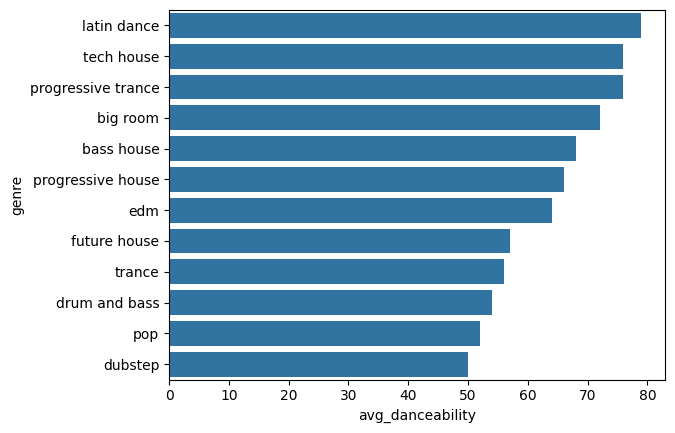

In [ ]:
plot_df = df_genres.dropna(subset=["avg_danceability"])

sns.barplot(x="avg_danceability", y="genre", data=plot_df)


## Story 2, up to five connector tracks between two styles


In [14]:
# Use the Camelot System to find matching songs. Then bridge from one song to another by finding songs that are similar to both.

